https://github.com/berndporr/py-ecg-detectors

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import argrelextrema

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/ECG_data/mitbih_train.csv",header=None)
df.head()


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df[df[187]==1].index

Int64Index([72471, 72472, 72473, 72474, 72475, 72476, 72477, 72478, 72479,
            72480,
            ...
            74684, 74685, 74686, 74687, 74688, 74689, 74690, 74691, 74692,
            74693],
           dtype='int64', length=2223)

In [ ]:
df.iloc[:,-1:].value_counts()

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
dtype: int64

In [ ]:
df2=df.iloc[:,:-1]
df2.shape

(87554, 187)

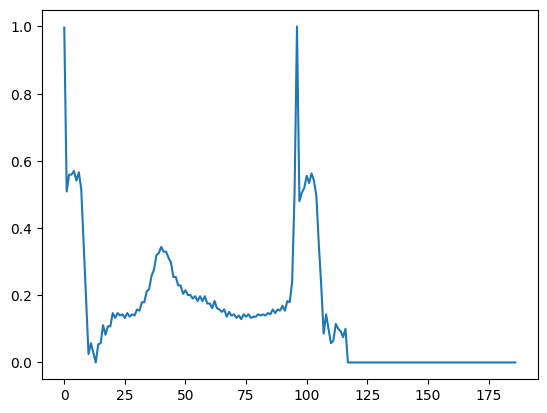

In [ ]:
df3=df2[70000:70010]
df3.shape
plt.plot(df2.loc[84779])

In [ ]:
listValues = df3.values.tolist()

In [ ]:
appendedList = []
for i in listValues:
    trimmed = np.trim_zeros(i)
    leftTrimIndex=0
    rightTrimIndex=len(trimmed)-1
    for j in range(1,len(trimmed)-1):
      if trimmed[j]<trimmed[j+1] and trimmed[j]<trimmed[j-1]:
        leftTrimIndex=j
        break
    for j in range(len(trimmed)-2,0,-1):
      if trimmed[j]<trimmed[j+1] and trimmed[j]<trimmed[j-1]:
        rightTrimIndex=j
        break
    # print(f"{len(trimmed)}:{leftTrimIndex}:{rightTrimIndex}")
    appendedList.append(trimmed[leftTrimIndex:rightTrimIndex+1])

In [ ]:
len(appendedList)

10

In [ ]:
x = list(np.concatenate(appendedList).flat)

In [ ]:
x = [i*2.5 for i in x]

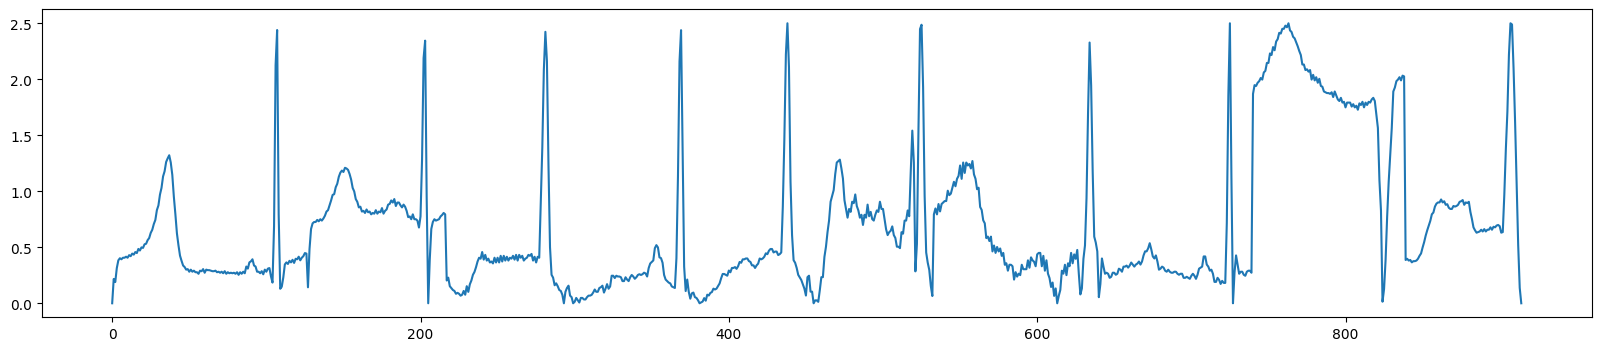

In [ ]:
plt.figure(figsize=(20, 4))  # Width: 10 inches, Height: 4 inches
plt.plot(x)

# Display the plot
plt.show()

In [ ]:
x=np.array(x)
x = x.reshape(-1, 1)

# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the data
normalized_data = scaler.fit_transform(x)

# Print the normalized data
# print(normalized_data)

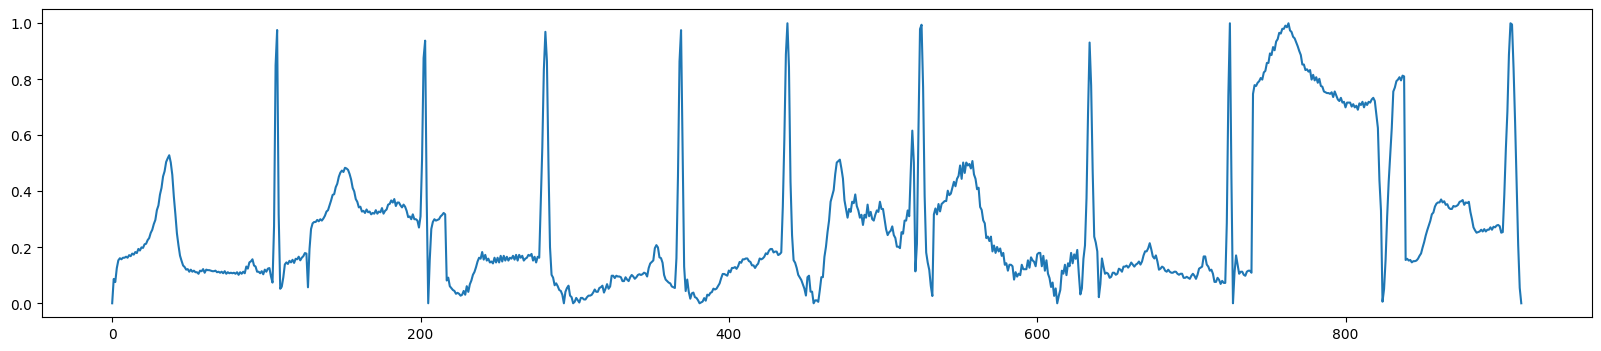

In [ ]:
plt.figure(figsize=(20, 4))  # Width: 10 inches, Height: 4 inches
plt.plot(normalized_data)

# Display the plot
plt.show()

In [ ]:
maxima_indices = argrelextrema(normalized_data, np.greater)
local_maxima = normalized_data[maxima_indices]

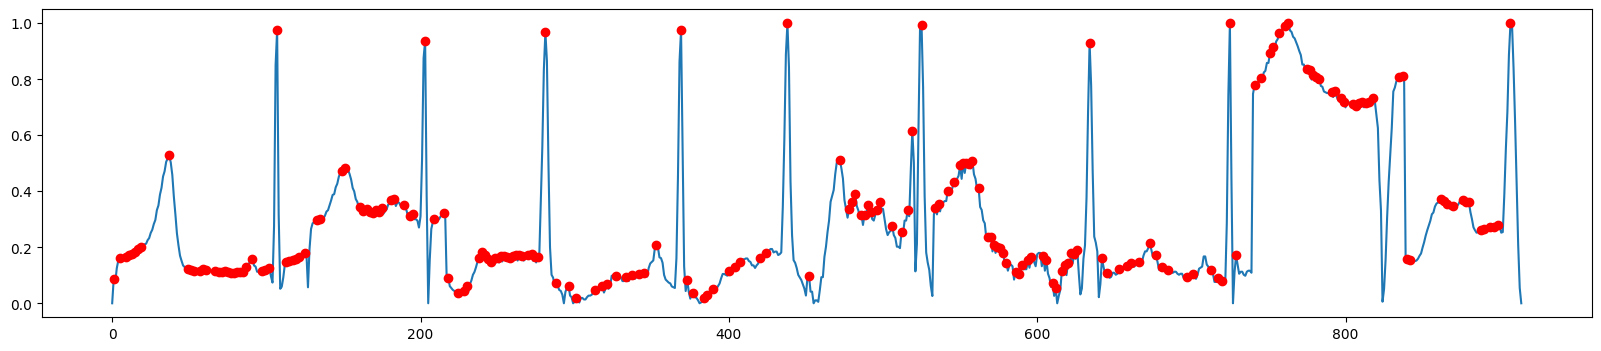

In [ ]:
# Find the indices of local maxima
maxima_indices = argrelextrema(normalized_data, np.greater)[0]
plt.figure(figsize=(20, 4))  # Width: 10 inches, Height: 4 inches

# Get the values of local maxima
local_maxima = normalized_data[maxima_indices]

# Generate x-coordinates for plotting
x = np.arange(len(normalized_data))

# Plot the data
plt.plot(x, normalized_data)

# Plot red dots at the points of local maxima
plt.plot(maxima_indices, local_maxima, 'ro')

# Display the plot
plt.show()


In [ ]:
threshold=0.83
cutoff_maxima_indices = list(filter(lambda x: normalized_data[x]>threshold, maxima_indices))

In [ ]:
cutoff_maxima_indices
cutoff_points=normalized_data[cutoff_maxima_indices]

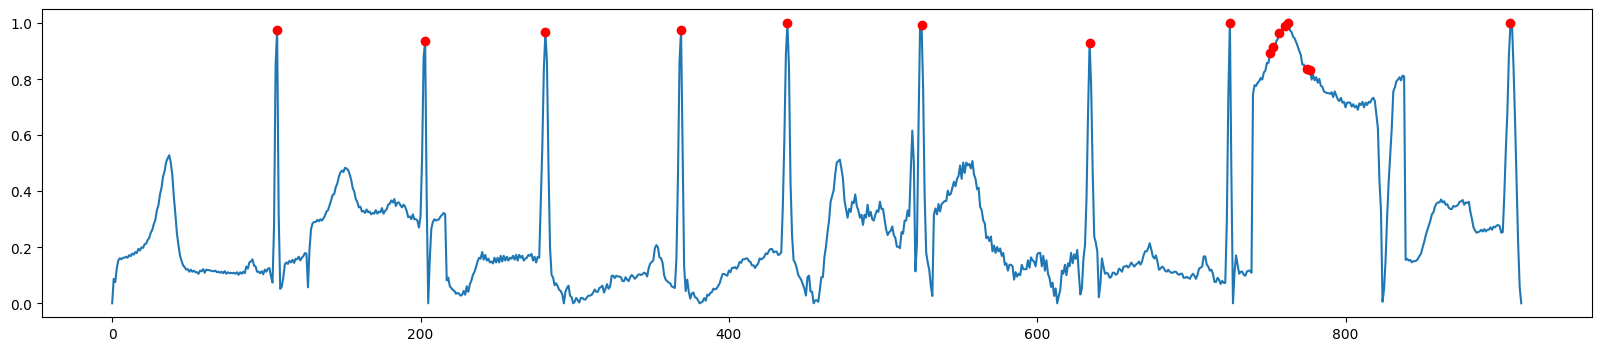

In [ ]:
# Generate x-coordinates for plotting
x = np.arange(len(normalized_data))
plt.figure(figsize=(20, 4))  # Width: 10 inches, Height: 4 inches
# Plot the data
plt.plot(x, normalized_data)

# Plot red dots at the points of local maxima
plt.plot(cutoff_maxima_indices, cutoff_points, 'ro')

# Display the plot
plt.show()

In [ ]:
prev=0
diff=[]
for i in cutoff_maxima_indices:
  diff.append(i-prev)
  prev=i
diff

[107, 96, 78, 88, 69, 87, 109, 91, 26, 2, 4, 4, 2, 12, 2, 130]

In [ ]:
median_r_peak=np.median(np.array(diff))*1.3
median_r_peak
# TODO: optimize median calculation (calculate median once (1st 10 seconds)only when patient is connected)

95.55

In [ ]:
beats=[]
for maxima in cutoff_maxima_indices:
  slice = normalized_data[int(maxima):int(maxima+median_r_peak)]
  pad = np.zeros((187-int(median_r_peak),1))
  beats.append(np.concatenate([slice,pad]))

In [ ]:
np.shape(beats)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(16,)

In [ ]:
beats = beats[:-1]

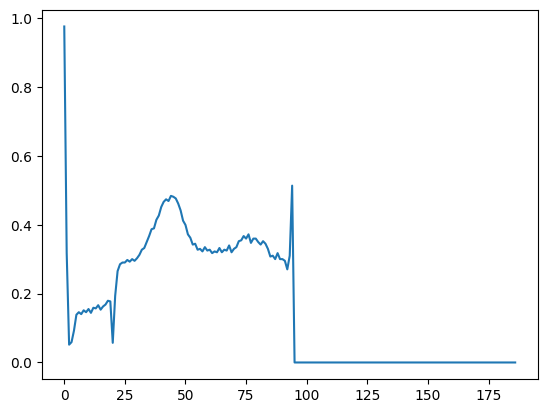

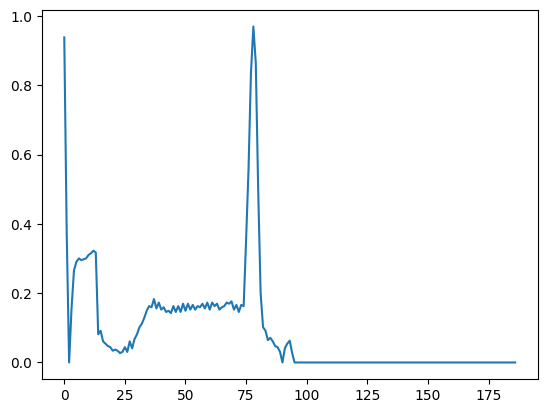

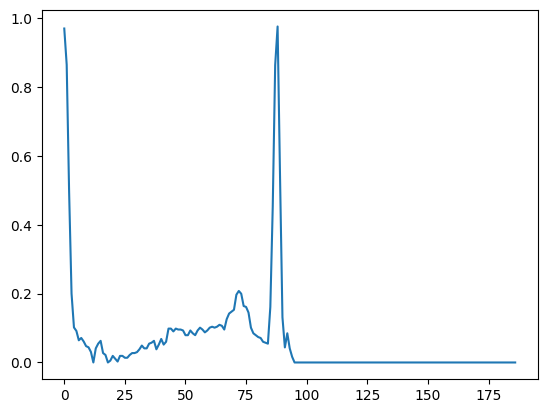

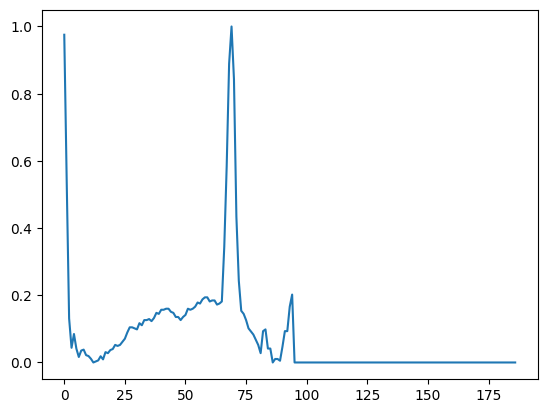

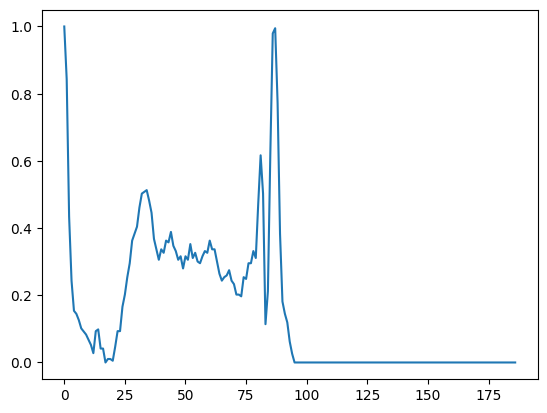

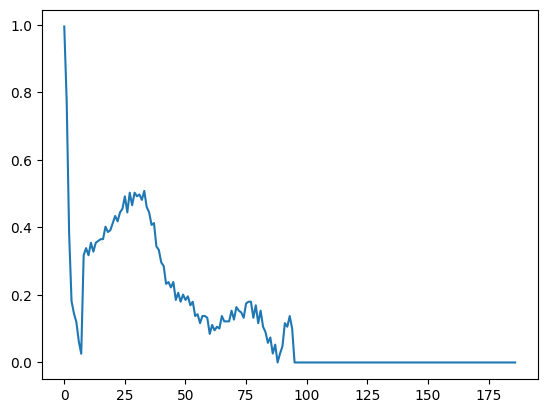

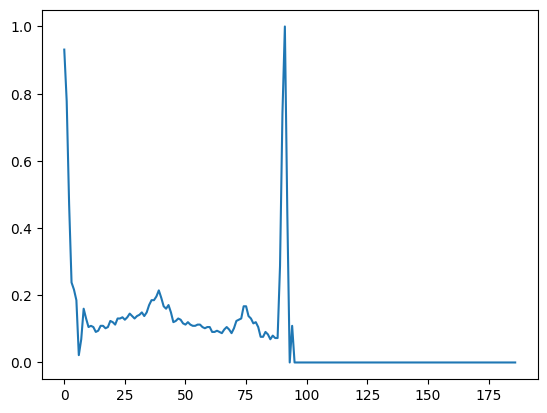

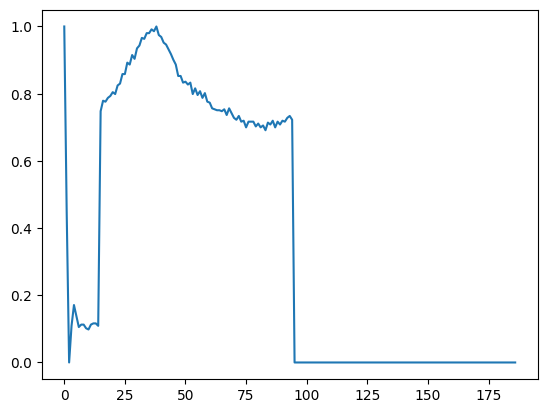

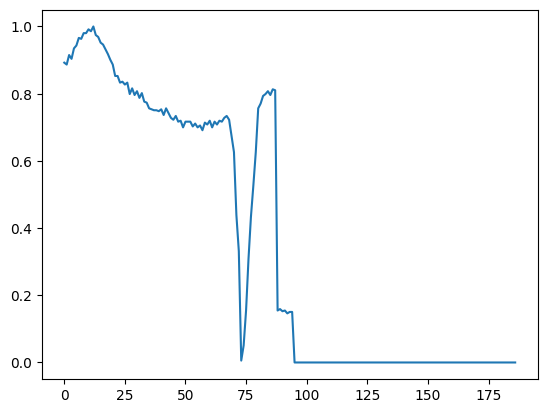

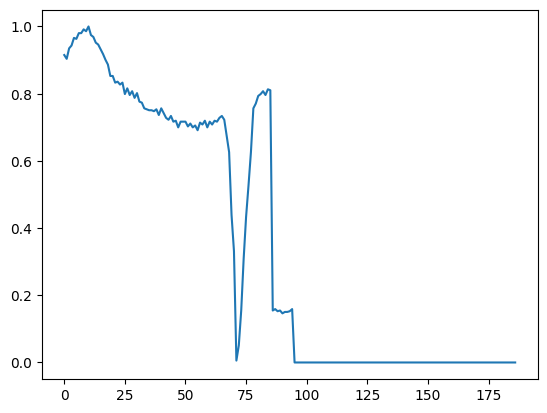

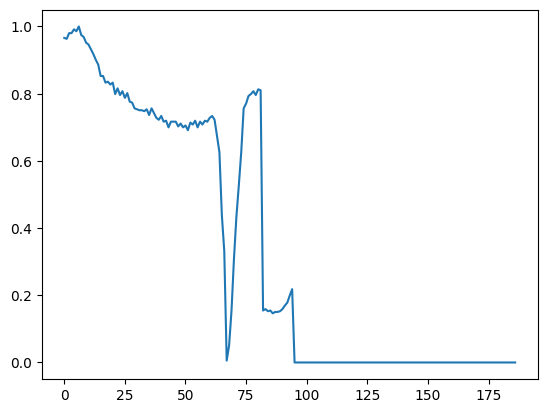

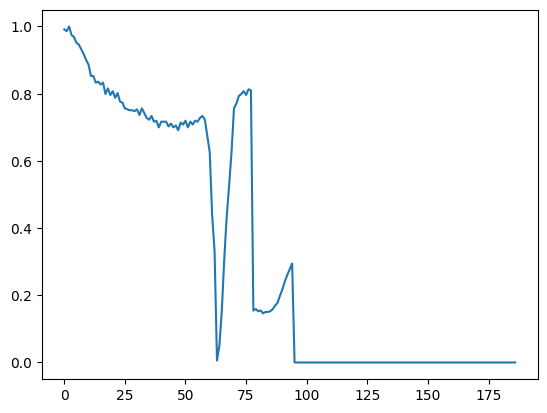

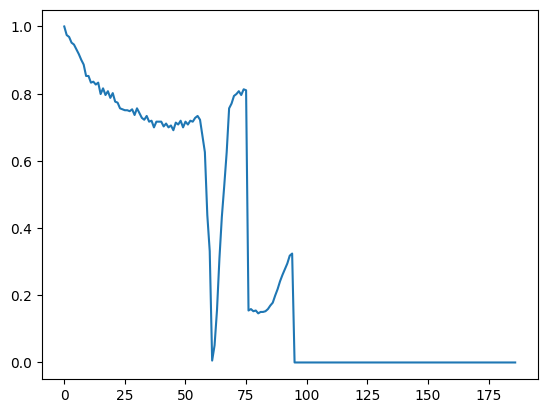

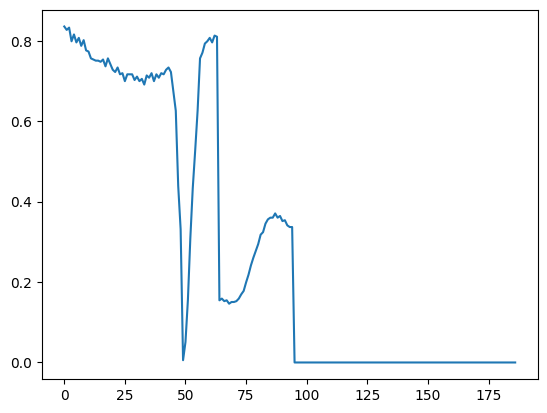

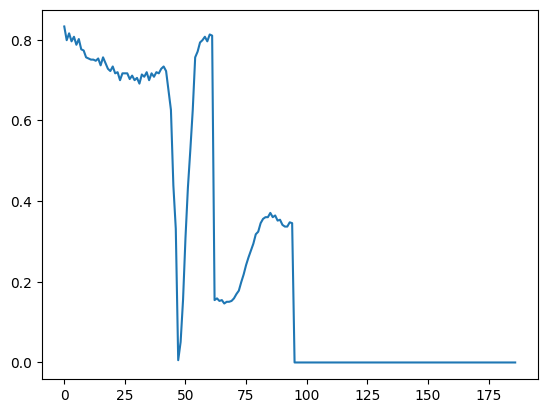

In [ ]:
for beat in beats:
  fig, ax = plt.subplots()

    # Plot the sublist
  ax.plot(beat)
  # plt.plot(beat)

In [ ]:
beats[7].ravel().tolist()

[1.0,
 0.4472727179527282,
 0.0,
 0.10909090936183928,
 0.1709090918302536,
 0.13818182051181793,
 0.10545454174280167,
 0.11272726953029633,
 0.11272726953029633,
 0.10181818157434464,
 0.0981818214058876,
 0.11272726953029633,
 0.11636363714933395,
 0.11636363714933395,
 0.10909090936183928,
 0.7478753328323364,
 0.779036819934845,
 0.7762039899826051,
 0.7875354290008546,
 0.7932011485099792,
 0.8045325875282286,
 0.798866868019104,
 0.8243626356124878,
 0.8300283551216124,
 0.8583569526672363,
 0.8583569526672363,
 0.8923512697219848,
 0.8866855502128601,
 0.9150141477584839,
 0.9036827087402344,
 0.9348441958427428,
 0.9433428049087523,
 0.9660056829452514,
 0.9631727933883667,
 0.9801699519157409,
 0.9801699519157409,
 0.9915013909339904,
 0.9858356714248656,
 1.0,
 0.9745042324066162,
 0.9688385128974913,
 0.9518413543701171,
 0.9461756348609923,
 0.932011306285858,
 0.9178470373153687,
 0.9008498787879946,
 0.8866855502128601,
 0.8526912331581116,
 0.8526912331581116,
 0.832861

In [ ]:
[1]*187

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

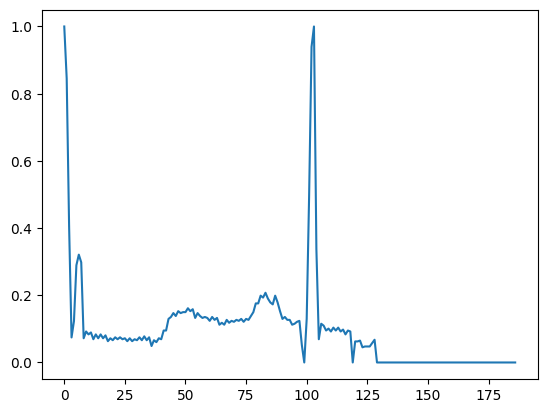

In [ ]:
plt.plot(beats[6])